In [1]:
import pandas as pd
import os
import pickle

In [2]:
from sklearn.utils import shuffle

file_path = '../Sup/dataset.csv'
dataset = pd.read_csv(file_path,header=None)
dataset = shuffle(dataset)
dataset.head()

,0,1,2
921,one of the top most influential directors.,DIRECTING#PERFORMANCE,Positive
53,"Uwe Boll is making a movie about Darfur,",DIRECTING#PERFORMANCE,Negative
545,great acting performance,CAST#PERFORMANCE,Positive
687,Fantastic. Under utilized Captain Marvel a bi...,CAST#PERFORMANCE,Positive
933,Chaplin is one of the best directors of all time.,DIRECTING#PERFORMANCE,Positive


In [3]:
data = dataset[0]
data.head()

921          one of the top  most influential directors.
53             Uwe Boll is making a movie about Darfur, 
545                             great acting performance
687    Fantastic.  Under utilized Captain Marvel a bi...
933    Chaplin is one of the best directors of all time.
Name: 0, dtype: object

In [4]:
label_cat = dataset[1]
label_cat.unique()

array(['DIRECTING#PERFORMANCE', 'CAST#PERFORMANCE'], dtype=object)

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [6]:
data = data.str.lower()
aspect_terms = []
for review in nlp.pipe(data):
    chunks = [chunk.root.text for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset[3] = aspect_terms

In [7]:
dataset.head()

,0,1,2,3
921,one of the top most influential directors.,DIRECTING#PERFORMANCE,Positive,directors
53,"Uwe Boll is making a movie about Darfur,",DIRECTING#PERFORMANCE,Negative,movie
545,great acting performance,CAST#PERFORMANCE,Positive,performance
687,Fantastic. Under utilized Captain Marvel a bi...,CAST#PERFORMANCE,Positive,send man
933,Chaplin is one of the best directors of all time.,DIRECTING#PERFORMANCE,Positive,directors time


In [9]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokeniz = pd.DataFrame(tokenizer.texts_to_matrix(dataset[3]))

In [18]:
#from sklearn.preprocessing import LabelEncoder
#import numpy as np
#from keras.utils import to_categorical

#label_encoder = LabelEncoder()
#integer_category = label_encoder.fit_transform(label_cat)

label_cate = label_cat.apply(lambda x:0 if x=="DIRECTING#PERFORMANCE" else 0).values
aspect_tokenized = aspect_tokeniz.loc[:899,:]
test_X = aspect_tokeniz.loc[900:,:]

dummy_category = label_cate[:900]
test_y = label_cate[900:]

In [12]:
#history = model.fit(aspect_tokenized, dummy_category, epochs=20, verbose=1)

Epoch 1/20
900/900 [==============================] - 1s 632us/step - loss: 0.4952 - accuracy: 0.9933
Epoch 2/20
900/900 [==============================] - 0s 255us/step - loss: 0.1421 - accuracy: 1.0000
Epoch 3/20
900/900 [==============================] 

In [14]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

0 899
2 887
Train on 899 samples, validate on 885 samples
Epoch 1/5
899/899 [==============================] - 0s 358us/step - loss: 2.8813e-04 - accuracy: 1.0000 - val_loss: 2.7866e-04 - val_accuracy: 1.0000
Epoch 2/5
899/899 [==============================] - 0s 349us/step - loss: 2.6448e-04 - accuracy: 1.0000 - val_loss: 2.5599e-04 - val_accuracy: 1.0000

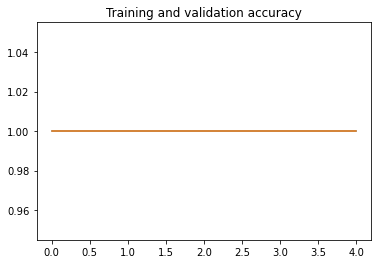

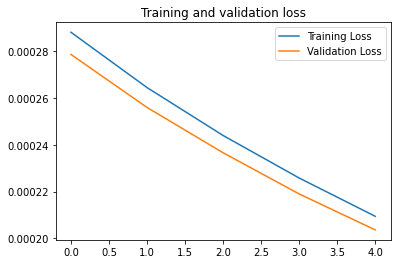

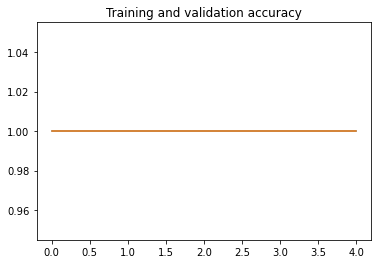

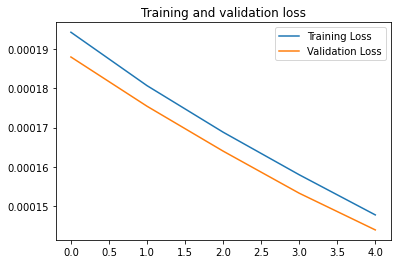

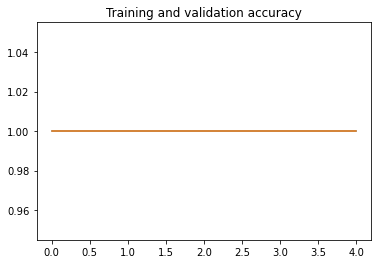

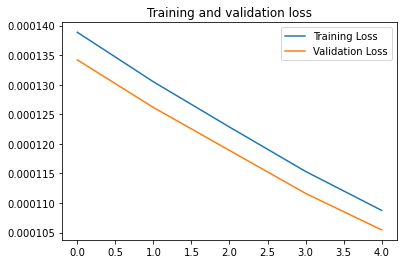

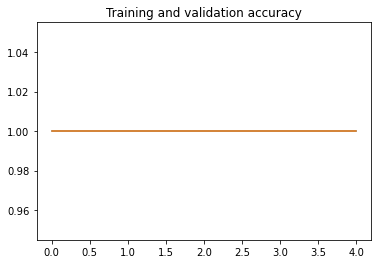

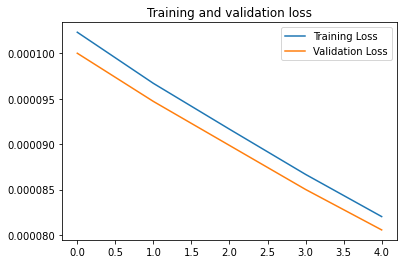

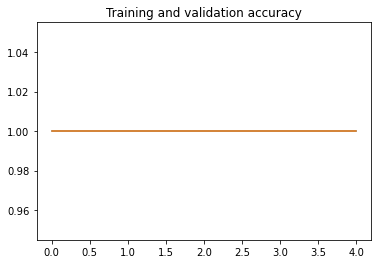

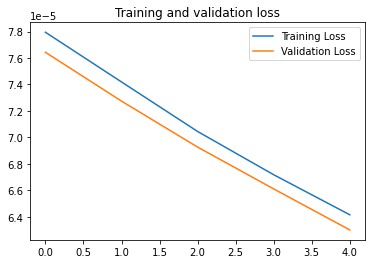

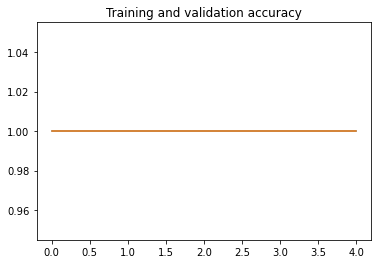

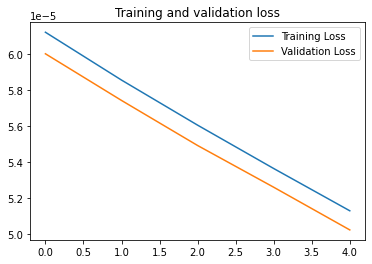

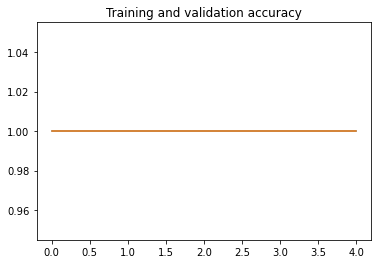

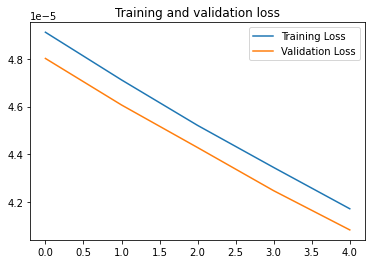

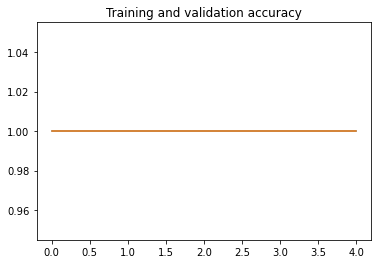

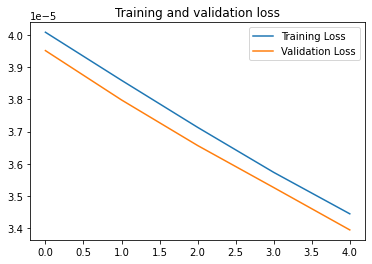

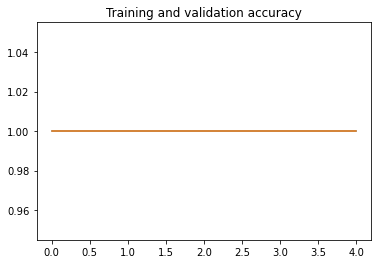

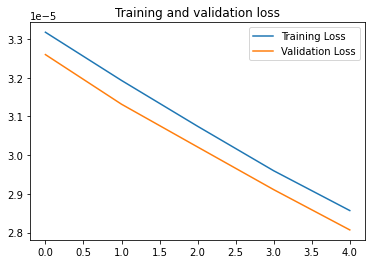

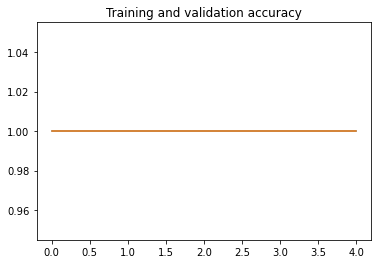

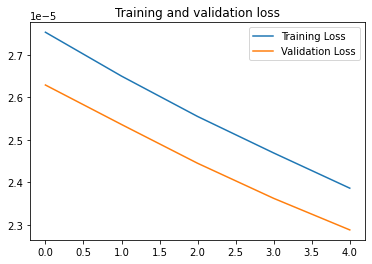

In [15]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokenized.loc[train_start:train_end-1,:],\
                                       aspect_tokenized.loc[test_start:test_end-1,:], \
                                       dummy_category[train_start:train_end], \
                                       dummy_category[test_start:test_end]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [16]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/categorical_model.h5')
model.save_weights( "../Sup/categorical_model_weights.h5")

In [20]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/categorical_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


evaluate the model on the test set

In [19]:
logs = model.evaluate(test_X,test_y)
print(logs)

100/100 [==============================] - 0s 189us/step
[4.001654961029999e-05, 1.0]
